<a href="https://colab.research.google.com/github/PunPK/AI-SleepDriving/blob/main/Yawn_ModelsfromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Strat

In [1]:
!pip install -Uqq fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 106.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 100.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 89.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import fastbook

In [3]:
from fastbook import *

In [4]:
import os
import os.path as op
import shutil
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [5]:
from torch import nn

from fastai.callback.hook import summary
from fastai.callback.schedule import fit_one_cycle, lr_find 
from fastai.callback.progress import ProgressCallback

from fastai.data.core import Datasets, DataLoaders, show_at
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import Categorize, GrandparentSplitter, parent_label, ToTensor, IntToFloatTensor, Normalize

from fastai.layers import Flatten
from fastai.learner import Learner

from fastai.metrics import accuracy, CrossEntropyLossFlat

from fastai.vision.augment import CropPad, RandomCrop, PadMode
from fastai.vision.core import PILImageBW
from fastai.vision.utils import get_image_files

# Working with the data

In [4]:
get_image_files("/content/drive/MyDrive/DataAiyawn/training/yawn")

(#0) []

In [5]:
get_image_files("/content/drive/MyDrive/DataAiyawn/testing/yawn")

(#0) []

In [6]:
items = get_image_files("/content/drive/MyDrive/DataAiyawn/")
items

(#4190) [Path('/content/drive/MyDrive/DataAiyawn/yawn/2131.jpg'),Path('/content/drive/MyDrive/DataAiyawn/yawn/2177.jpg'),Path('/content/drive/MyDrive/DataAiyawn/yawn/215.jpg'),Path('/content/drive/MyDrive/DataAiyawn/yawn/2149.jpg'),Path('/content/drive/MyDrive/DataAiyawn/yawn/2190.jpg'),Path('/content/drive/MyDrive/DataAiyawn/yawn/2271.jpg'),Path('/content/drive/MyDrive/DataAiyawn/yawn/2187.jpg'),Path('/content/drive/MyDrive/DataAiyawn/yawn/2163.jpg'),Path('/content/drive/MyDrive/DataAiyawn/yawn/2142.jpg'),Path('/content/drive/MyDrive/DataAiyawn/yawn/2189.jpg')...]

In [7]:
items[0]

Path('/content/drive/MyDrive/DataAiyawn/yawn/2131.jpg')

In [8]:
parent_label("/content/drive/MyDrive/DataAiyawn")

'MyDrive'

<Axes: >

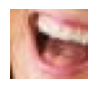

In [9]:
im = PILImage.create(items[0])
im.show()

In [10]:
splits = RandomSplitter(valid_pct=0.2, seed=42)

In [11]:
items[:3]

(#3) [Path('/content/drive/MyDrive/DataAiyawn/yawn/2131.jpg'),Path('/content/drive/MyDrive/DataAiyawn/yawn/2177.jpg'),Path('/content/drive/MyDrive/DataAiyawn/yawn/215.jpg')]

In [12]:
splits = splits(items)

In [13]:
splits[0][:5], splits[1][:5]

((#5) [257,3817,2492,4098,1578], (#5) [172,3280,3630,3749,3102])

In [14]:
dsrc = Datasets(items, tfms=[[PILImage.create], [parent_label, Categorize]], 
                  splits=splits)

<Axes: title={'center': 'no yawn'}>

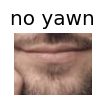

In [15]:
show_at(dsrc.train, 3)

In [16]:
tfms = [ToTensor(), RandomResizedCrop(224, min_scale=0.5) ]
#tfms = [ToTensor(), CropPad(size=34, pad_mode=PadMode.Zeros), RandomCrop(size=28)]
#tfms = [ToTensor(), CropPad(size=224, pad_mode=PadMode.Zeros), RandomCrop(size=224)]

In [17]:
gpu_tfms = [IntToFloatTensor(), Normalize()]

In [18]:
dls = dsrc.dataloaders(bs=128, after_item=tfms, after_batch=gpu_tfms)

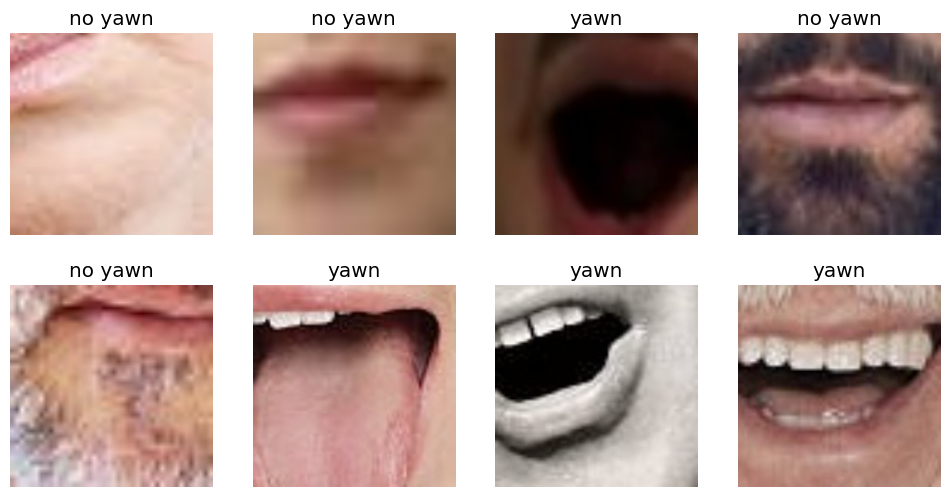

In [19]:
dls.show_batch(max_n=8, nrows=2)

In [20]:
xb, yb = dls.one_batch()

In [21]:
xb.shape, yb.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

In [22]:
dls.c

2

# The Model

In [23]:
def conv(ni, nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [24]:
def bn(nf): return nn.BatchNorm2d(nf)

In [25]:
def ReLU(): return nn.ReLU(inplace=False)

In [26]:
Flatten()

fastai.layers.Flatten(full=False)

# Making a Model

In [27]:
model = nn.Sequential(
    conv(3, 8),
    bn(8),
    ReLU(),
    conv(8, 16),
    bn(16),
    ReLU(),
    conv(16,32),
    bn(32),
    ReLU(),
    conv(32, 16),
    bn(16),
    ReLU(),
    conv(16, 10),
    bn(10),
    Flatten()
)

In [28]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [29]:
learn.summary()

Sequential (Input shape: 128 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 8 x 112 x 112 
Conv2d                                    224        True      
BatchNorm2d                               16         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 16 x 56 x 56  
Conv2d                                    1168       True      
BatchNorm2d                               32         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 32 x 28 x 28  
Conv2d                                    4640       True      
BatchNorm2d                               64         True      
ReLU                                                           
__________________________________

SuggestedLRs(valley=0.00363078061491251)

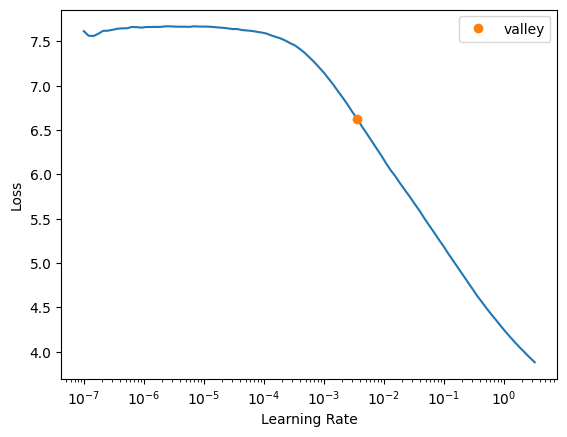

In [32]:
learn.lr_find()

SuggestedLRs(valley=0.0020892962347716093)

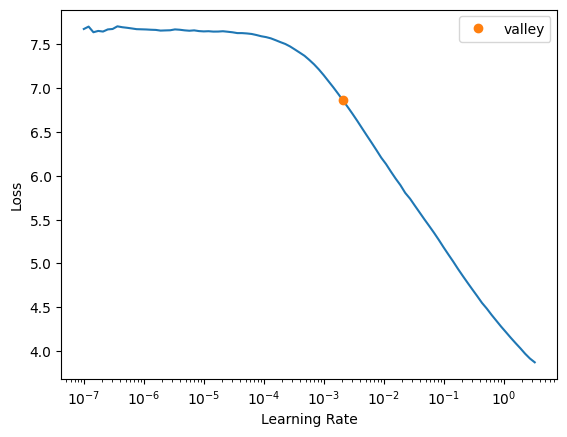

In [35]:
learn.lr_find()

In [36]:
learn.fit_one_cycle(4, lr_max=0.0020892962347716093)

epoch,train_loss,valid_loss,accuracy,time
0,5.583479,5.219145,0.482100,01:41
1,4.085385,3.008546,0.497613,00:40
2,3.494228,2.811354,0.497613,00:40
3,3.181988,2.779156,0.497613,00:38
4,3.007959,2.794257,0.497613,00:38


# Simplify it

In [30]:
def conv2(ni, nf): return ConvLayer(ni, nf, stride=2)

In [31]:
net = nn.Sequential(
    conv2(3,8),
    conv2(8,16),
    conv2(16,32),
    conv2(32,16),
    conv2(16,10),
    Flatten()
)

In [32]:
learn = Learner(dls, net, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

SuggestedLRs(valley=0.005248074419796467)

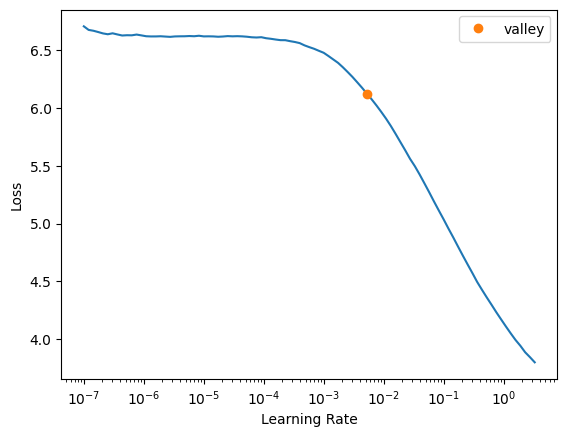

In [40]:
learn.lr_find()

In [41]:
learn.fit_one_cycle(4, lr_max=0.005248074419796467)

epoch,train_loss,valid_loss,accuracy,time
0,5.280896,4.835937,0.260143,00:39
1,3.878514,2.653405,0.497613,00:40
2,3.223463,2.419374,0.497613,00:37
3,2.847723,2.329821,0.497613,00:39
4,2.633640,2.348047,0.497613,00:39


# ResNet (kinda)

In [33]:
class ResBlock(Module):
  def __init__(self, nf):
    self.conv1 = ConvLayer(nf, nf)
    self.conv2 = ConvLayer(nf, nf)
  
  def forward(self, x): return x + self.conv2(self.conv1(x))

In [34]:
net = nn.Sequential(
    conv2(3,8),
    ResBlock(8),
    conv2(8,16),
    ResBlock(16),
    conv2(16,32),
    ResBlock(32),
    conv2(32,16),
    ResBlock(16),
    conv2(16,10),
    Flatten()
)

In [35]:
net

Sequential(
  (0): ConvLayer(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ResBlock(
    (conv1): ConvLayer(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): ConvLayer(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (2): ConvLayer(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): ResBlock(
    (conv1): ConvLayer(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride

In [36]:
def conv_and_res(ni, nf): return nn.Sequential(conv2(ni, nf), ResBlock(nf))

In [37]:
net = nn.Sequential(
    conv_and_res(3,8),
    conv_and_res(8,16),
    conv_and_res(16,32),
    conv_and_res(32,16),
    conv2(16,10),
    Flatten()
)

In [38]:
learn = Learner(dls, net, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

SuggestedLRs(valley=0.0020892962347716093)

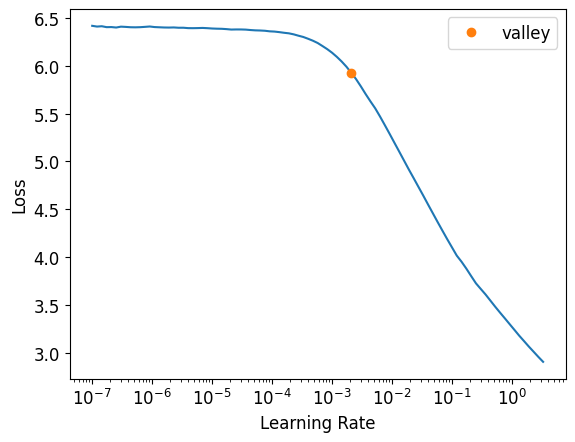

In [39]:
learn.lr_find()

In [41]:
learn.fit_one_cycle(20, lr_max=0.0020892962347716093)

epoch,train_loss,valid_loss,accuracy,time
0,5.928515,5.593191,0.016706,01:31
1,4.758653,3.262010,0.484487,00:52
2,3.464724,1.311077,0.584726,00:48
3,2.610427,1.321795,0.653938,00:51
4,2.049732,1.201535,0.724344,00:50
5,1.636367,0.934268,0.772076,00:50
6,1.315031,0.738935,0.813842,00:47
7,1.086643,0.692121,0.810263,00:47
8,0.896723,0.720631,0.841289,00:48
9,0.761250,0.473671,0.861575,00:46


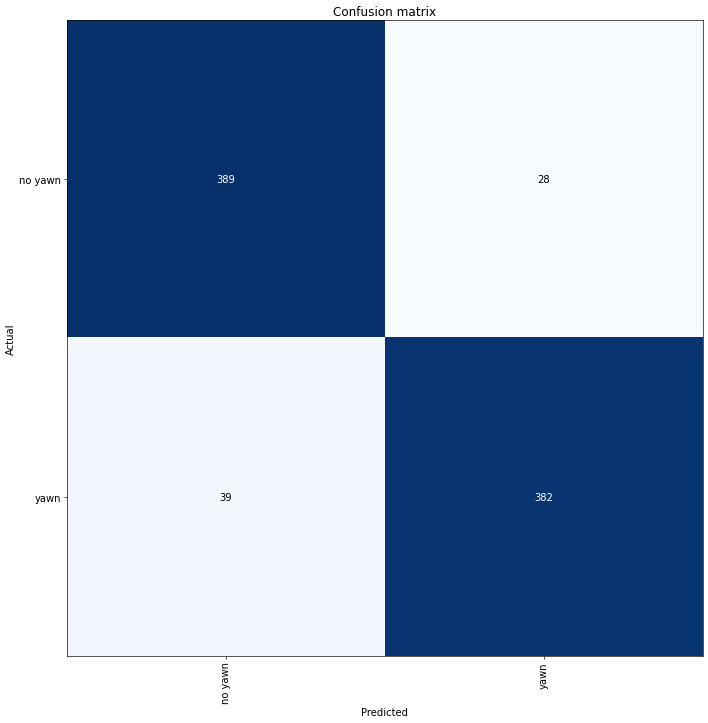

In [42]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [43]:
interp.most_confused(min_val=5)

[('yawn', 'no yawn', 39), ('no yawn', 'yawn', 28)]

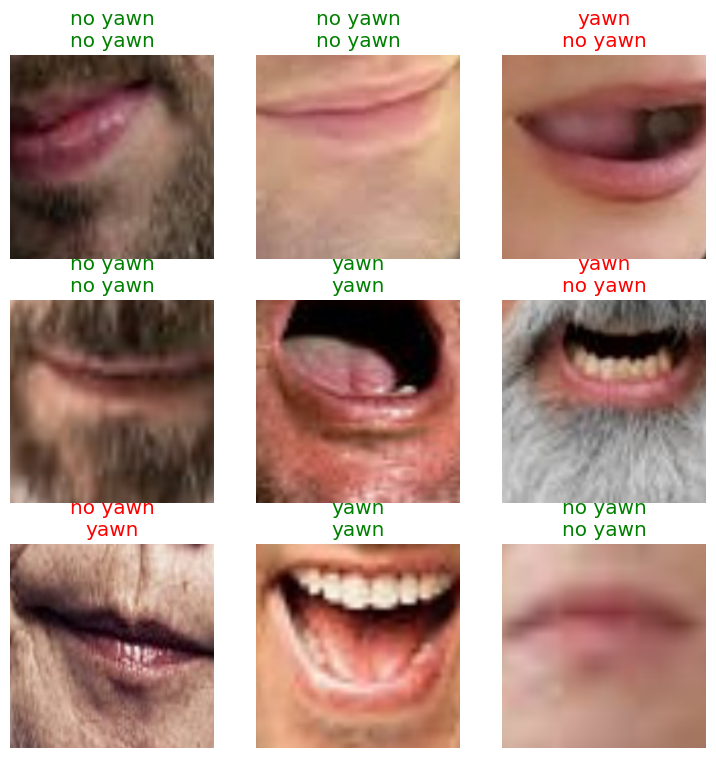

In [44]:
learn.show_results(shuffle=True)

In [49]:
learn.predict("/content/drive/MyDrive/DataAiyawn/yawn/2128.jpg")

('yawn',
 tensor(1),
 tensor([4.0146e-04, 9.2169e-01, 2.8710e-04, 3.1016e-04, 1.5035e-04, 1.5035e-04, 1.5035e-04, 2.4263e-04, 1.6199e-04, 1.5035e-04, 1.8429e-04, 2.1780e-04, 1.9128e-04, 1.5035e-04, 1.9085e-04, 1.6031e-04,
         1.5035e-04, 2.0698e-04, 1.7145e-04, 1.5933e-04, 1.5035e-04, 2.0730e-04, 1.5035e-04, 1.6187e-04, 2.2943e-04, 1.9355e-04, 1.5836e-04, 1.5035e-04, 1.6867e-04, 1.6146e-04, 1.6054e-04, 1.8628e-04,
         1.5035e-04, 1.6475e-04, 1.5035e-04, 1.9621e-04, 1.5035e-04, 1.5035e-04, 2.0743e-04, 1.7393e-04, 1.5749e-04, 1.5400e-04, 1.5035e-04, 1.8000e-04, 1.5663e-04, 1.6755e-04, 1.5035e-04, 1.5035e-04,
         1.7684e-04, 1.5035e-04, 2.1071e-04, 1.5507e-04, 1.6219e-04, 1.7183e-04, 1.5894e-04, 1.5035e-04, 1.7692e-04, 1.5035e-04, 1.5035e-04, 1.5035e-04, 1.5035e-04, 1.5035e-04, 1.5035e-04, 1.5035e-04,
         1.5035e-04, 1.5035e-04, 1.5035e-04, 1.5035e-04, 1.5035e-04, 1.5035e-04, 1.5035e-04, 1.5035e-04, 1.5035e-04, 1.5035e-04, 1.5035e-04, 1.5035e-04, 1.5035e-04, 1.5035e-04

In [ ]:
learn.export("yawn_ModelsfromScratch.pkl")

In [48]:
learn.path = Path('')
learn.export(fname= "yawn_ModelsfromScratch.pkl")